## Define the correct data type for each column in the datasets

In [1]:
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
from  datetime import datetime, timedelta

### *calendar.csv*

In [17]:
# Correct data types for "calendar.csv"
calendarDTypes = {"event_name_1": "category", 
                  "event_name_2": "category", 
                  "event_type_1": "category", 
                  "event_type_2": "category", 
                  "weekday": "category", 
                  'wm_yr_wk': 'int16', 
                  "wday": "int16",
                  "month": "int16", 
                  "year": "int16", 
                  "snap_CA": "float32", 
                  'snap_TX': 'float32', 
                  'snap_WI': 'float32' }

# Read csv file
calendar = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv", 
                       dtype = calendarDTypes)

calendar["date"] = pd.to_datetime(calendar["date"])

# Transform categorical features into integers
for col, colDType in calendarDTypes.items():
    if colDType == "category":
        calendar[col] = calendar[col].cat.codes.astype("int16")
        calendar[col] -= calendar[col].min()

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0.0,0.0,0.0
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0.0,0.0,0.0
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0.0,0.0,0.0
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1.0,1.0,0.0
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1.0,0.0,1.0


### *sell_prices.csv*

In [16]:
# Correct data types for "sell_prices.csv"
priceDTypes = {"store_id": "category", 
               "item_id": "category", 
               "wm_yr_wk": "int16",
               "sell_price":"float32"}

# Read csv file
prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv", 
                     dtype = priceDTypes)

# Transform categorical features into integers
for col, colDType in priceDTypes.items():
    if colDType == "category":
        prices[col] = prices[col].cat.codes.astype("int16")
        prices[col] -= prices[col].min()
        
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,0,0,11325,9.58
1,0,0,11326,9.58
2,0,0,11327,8.26
3,0,0,11328,8.26
4,0,0,11329,8.26


### *sales_train_validation.csv*

In [4]:
firstDay = 250
lastDay = 1913

# Use x sales days (columns) for training
numCols = [f"d_{day}" for day in range(firstDay, lastDay+1)]

# Define all categorical columns
catCols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']

# Define the correct data types for "sales_train_validation.csv"
dtype = {numCol: "float32" for numCol in numCols} 
dtype.update({catCol: "category" for catCol in catCols if catCol != "id"})

# Read csv file
ds = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                 usecols = catCols + numCols, dtype = dtype)

# Transform categorical features into integers
for col in catCols:
    if col != "id":
        ds[col] = ds[col].cat.codes.astype("int16")
        ds[col] -= ds[col].min()
        
ds = pd.melt(ds,
             id_vars = catCols,
             value_vars = [col for col in ds.columns if col.startswith("d_")],
             var_name = "d",
             value_name = "sales")

# Merge "ds" with "calendar" and "prices" dataframe
ds = ds.merge(calendar, on = "d", copy = False)
ds = ds.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

ds.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_250,0.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,3.97
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_250,0.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,4.34
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_250,0.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,2.48
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_250,1.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,0.50
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_250,2.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,1.77


## Create features

### Sales features

In [5]:
dayLags = [7, 28]
lagSalesCols = [f"lag_{dayLag}" for dayLag in dayLags]
for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
    ds[lagSalesCol] = ds[["id","sales"]].groupby("id")["sales"].shift(dayLag)
    
windows = [7, 28]
for window in windows:
    for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
        ds[f"rmean_{dayLag}_{window}"] = ds[["id", lagSalesCol]].groupby("id")[lagSalesCol].transform(lambda x: x.rolling(window).mean())

### Date features

In [6]:
dateFeatures = {
    "wday": "weekday",
    "week": "week",        
    "month": "month",
    "quarter": "quarter",
    "year": "year",
    "mday": "day"
}

for featName, featFunc in dateFeatures.items():
    if featName in ds.columns:
        ds[featName] = ds[featName].astype("int16")
    elif featFunc == "week":
        ds[featName] = ds["date"].dt.isocalendar().week.astype("int16")
    else:
        ds[featName] = getattr(ds["date"].dt, featFunc).astype("int16")

In [7]:
ds.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_250,0.0,2011-10-05,11136,...,3.97,NaN,NaN,NaN,NaN,NaN,NaN,40,4,5
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_250,0.0,2011-10-05,11136,...,4.34,NaN,NaN,NaN,NaN,NaN,NaN,40,4,5
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_250,0.0,2011-10-05,11136,...,2.48,NaN,NaN,NaN,NaN,NaN,NaN,40,4,5
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_250,1.0,2011-10-05,11136,...,0.50,NaN,NaN,NaN,NaN,NaN,NaN,40,4,5
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_250,2.0,2011-10-05,11136,...,1.77,NaN,NaN,NaN,NaN,NaN,NaN,40,4,5


In [8]:
ds.dtypes

id                      object
item_id                  int16
dept_id                  int16
store_id                 int16
cat_id                   int16
state_id                 int16
d                       object
sales                  float32
date            datetime64[ns]
wm_yr_wk                 int16
weekday                  int16
wday                     int16
month                    int16
year                     int16
event_name_1             int16
event_type_1             int16
event_name_2             int16
event_type_2             int16
snap_CA                float32
snap_TX                float32
snap_WI                float32
sell_price             float32
lag_7                  float32
lag_28                 float32
rmean_7_7              float64
rmean_28_7             float64
rmean_7_28             float64
rmean_28_28            float64
week                     int16
quarter                  int16
mday                     int16
dtype: object

In [9]:
# Save on memory: 
# Downcast float64 to float32
float64_cols = ['rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28']
ds[float64_cols] = ds[float64_cols].astype(np.float32)

# Downcast object columns where possible
# If 'id' and 'd' are repetitive strings, convert to category
ds['id'] = ds['id'].astype('category')
ds['d'] = ds['d'].astype('category')

# Optional: convert 'date' to datetime if not already
ds['date'] = pd.to_datetime(ds['date'])

# Confirm memory usage improvement
print(ds.info(memory_usage='deep'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372682 entries, 0 to 42372681
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             category      
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [10]:
ds.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_7', 'lag_28',
       'rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week',
       'quarter', 'mday'],
      dtype='object')

In [11]:
feature_cols = [
    'event_type_1','event_type_2', 'sell_price', 'weekday', 'quarter', 'snap_CA', 'snap_TX', 'snap_WI', 'lag_28', 'lag_7', 'store_id'
]

In [12]:
for col in ['sell_price', 'lag_7', 'lag_28']:
    mean = ds[col].mean()
    std = ds[col].std()
    ds[col] = (ds[col] - mean) / std

In [13]:
ds = ds.dropna(subset=feature_cols + ['sales'])  # Drop rows with any NaN in model features or target

### Split dataset into train and validation set

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

# Parameters
sequence_length = 28  # Number of past days to look at
forecast_horizon = 1  # Predict 1 day ahead

# Only use a subset of IDs to keep memory manageable
sample_ids = ds['id'].unique()  # Adjust this based on available memory


# Memory optimization, don't keep more than 
max_seqs_per_item = 100  # or any number that keeps memory safe

# Sort by 'd' for proper sequencing
ds = ds.sort_values(['id', 'd'])



# Create sequences
X_seqs = []
y_seqs = []

# Build sequences
for item_id in sample_ids:
    group = ds[ds['id'] == item_id]

    feature_matrix = group[feature_cols].values.astype(np.float32)
    target_series = group['sales'].values.astype(np.float32)

    total = len(target_series) - sequence_length - forecast_horizon
    if total <= 0:
        continue

    for i in range(min(total, max_seqs_per_item)):
        X_seqs.append(feature_matrix[i:i+sequence_length]) 
        y_seqs.append(target_series[i + sequence_length + forecast_horizon - 1])

# Convert to arrays
X_seqs = np.array(X_seqs)  # shape: (samples, timesteps, features)
y_seqs = np.array(y_seqs)

# Train-validation split
X_train_seq, X_val_seq, y_train, y_val = train_test_split(X_seqs, y_seqs, test_size=0.2, random_state=42)

print("X_train_seq shape:", X_train_seq.shape)
print("y_train shape:", y_train.shape)

X_train_seq shape: (2437979, 28, 11)
y_train shape: (2437979,)


In [15]:
# Reduce Memory storange by deleting main dataframe but keeping imports for calendar, prices, sales
del ds
import gc
gc.collect()

0

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Assume `X_train_seq`, `y_train`, `X_val_seq`, `y_val` are already created and shaped as (samples, timesteps, features)


model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=4,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


2025-05-04 14:00:22.100074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746367222.118114     142 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746367222.123632     142 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746367225.728519     142 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Epoch 1/4


I0000 00:00:1746367237.895848     206 cuda_dnn.cc:529] Loaded cuDNN version 90300


38094/38094 ━━━━━━━━━━━━━━━━━━━━ 248s 6ms/step - loss: 8.7373 - mse: 8.7373 - val_loss: 7.1789 - val_mse: 7.1789
Epoch 2/4
38094/38094 ━━━━━━━━━━━━━━━━━━━━ 243s 6ms/step - loss: 7.2930 - mse: 7.2930 - val_loss: 7.2146 - val_mse: 7.2146
Epoch 3/4
38094/38094 ━━━━━━━━━━━━━━━━━━━━ 252s 7ms/step - loss: 7.2746 - mse: 7.2746 - val_loss: 7.1587 - val_mse: 7.1587
Epoch 4/4
38094/38094 ━━━━━━━━━━━━━━━━━━━━ 249s 7ms/step - loss: 7.5453 - mse: 7.5453 - val_loss: 6.9544 - val_mse: 6.9544


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 28, 64)              │          14,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,677 (283.90 KB)

 Trainable params: 24,225 (94.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,452 (189.27 KB)

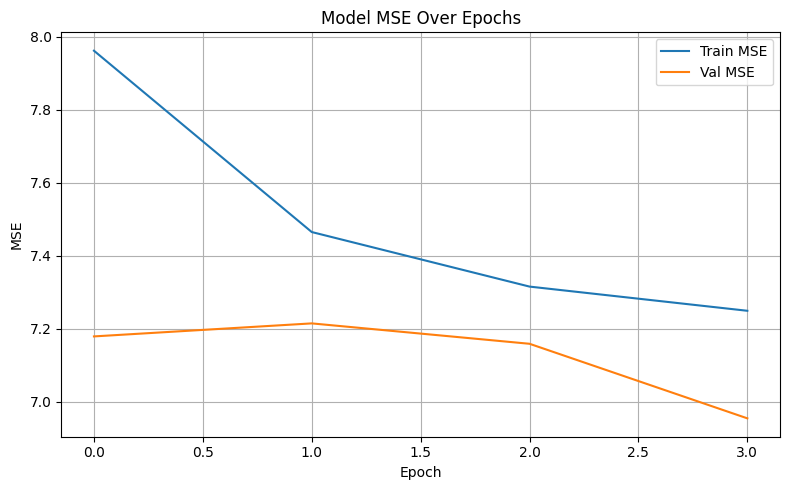

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.title('Model MSE Over Epochs')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Save down the model so you don't lose it when kernel crashes for evalatuation
model.save('/kaggle/working/gru_model.h5')

In [20]:
import os
model.save('/kaggle/working/gru_model.h5')
print("Saved:", os.path.exists('/kaggle/working/gru_model.h5'))


Saved: True


# Submission

In [1]:

from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/gru_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse')

2025-05-04 14:35:45.933384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746369346.113191     401 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746369346.159921     401 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746369353.723537     401 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [18]:
import pandas as pd
# Step 1: Load base data
sales_eval = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv',low_memory=False)
sales_eval = sales_eval.astype({col: 'float32' for col in sales_eval.columns if col.startswith('d_')})

In [19]:
# Step 2: Reshape it to long format
sales_long = sales_eval.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                             var_name='d', value_name='sales')

prices['store_id'] = prices['store_id'].astype(str)
prices['item_id'] = prices['item_id'].astype(str)

In [20]:
# Step 3: Merge with calendar and price data
sales_long = sales_long.merge(calendar, on='d', how='left')
sales_long = sales_long.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [21]:
# Clean up but keep sales long dataframe
del sales_eval, calendar, prices
import gc
gc.collect()

8

In [22]:
import numpy as np
import pandas as pd
# Step 4: Engineer features — just like you did for training
# (encode events, create lags, normalize, etc.)

## ========== Create Lag Features ========
dayLags = [7, 28]
lagSalesCols = [f"lag_{dayLag}" for dayLag in dayLags]
for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
    sales_long[lagSalesCol] = sales_long[["id","sales"]].groupby("id")["sales"].shift(dayLag)
    
windows = [7, 28]
for window in windows:
    for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
        sales_long[f"rmean_{dayLag}_{window}"] = sales_long[["id", lagSalesCol]].groupby("id")[lagSalesCol].transform(lambda x: x.rolling(window).mean())


## ====== Day Features ========
dateFeatures = {
    "wday": "weekday",
    "week": "week",        
    "month": "month",
    "quarter": "quarter",
    "year": "year",
    "mday": "day"
}

for featName, featFunc in dateFeatures.items():
    if featName in sales_long.columns:
        sales_long[featName] = sales_long[featName].astype("int16")
    elif featFunc == "week":
        sales_long[featName] = sales_long["date"].dt.isocalendar().week.astype("int16")
    else:
        sales_long[featName] = getattr(sales_long["date"].dt, featFunc).astype("int16")

## ====== Memory =======
# Save on memory: 
# Downcast float64 to float32
float64_cols = ['rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28']
sales_long[float64_cols] = sales_long[float64_cols].astype(np.float32)

# Downcast object columns where possible
# If 'id' and 'd' are repetitive strings, convert to category
sales_long['id'] = sales_long['id'].astype('category')
sales_long['d'] = sales_long['d'].astype('category')

# Optional: convert 'date' to datetime if not already
sales_long['date'] = pd.to_datetime(sales_long['date'])

# Confirm memory usage improvement
print(sales_long.info(memory_usage='deep'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       object        
 2   dept_id       object        
 3   cat_id        object        
 4   store_id      object        
 5   state_id      object        
 6   d             category      
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

In [23]:
feature_cols = [
    'event_type_1','event_type_2', 'sell_price', 'weekday', 'quarter', 'snap_CA', 'snap_TX', 'snap_WI', 'lag_28', 'lag_7', 'store_id'
]

In [24]:
from sklearn.preprocessing import LabelEncoder

for col in feature_cols:
    if sales_long[col].dtype == 'object' or str(sales_long[col].dtype).startswith('category'):
        le = LabelEncoder()
        sales_long[col] = le.fit_transform(sales_long[col].astype(str))

In [25]:
sales_long[feature_cols] = sales_long[feature_cols].fillna(0)

In [32]:
sales_long['sell_price'] = sales_long['sell_price'].fillna(0)

In [33]:
sales_long.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,CA,d_1,0.0,2011-01-29,11101,...,0.0,-0.302092,-0.299114,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,CA,d_1,0.0,2011-01-29,11101,...,0.0,-0.302092,-0.299114,NaN,NaN,NaN,NaN,4,1,29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,CA,d_1,0.0,2011-01-29,11101,...,0.0,-0.302092,-0.299114,NaN,NaN,NaN,NaN,4,1,29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,CA,d_1,0.0,2011-01-29,11101,...,0.0,-0.302092,-0.299114,NaN,NaN,NaN,NaN,4,1,29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,CA,d_1,0.0,2011-01-29,11101,...,0.0,-0.302092,-0.299114,NaN,NaN,NaN,NaN,4,1,29


In [34]:
for col in ['sell_price', 'lag_7', 'lag_28']:
    mean = sales_long[col].mean()
    std = sales_long[col].std()
    sales_long[col] = (sales_long[col] - mean) / std

In [36]:
sales_long['sell_price'] = sales_long['sell_price'].fillna(0)

In [37]:
print(sales_long[feature_cols].isna().sum())


event_type_1    0
event_type_2    0
sell_price      0
weekday         0
quarter         0
snap_CA         0
snap_TX         0
snap_WI         0
lag_28          0
lag_7           0
store_id        0
dtype: int64


In [40]:
# Prepare input
sequence_length = 28  # Number of past days to look at
forecast_horizon = 28

forecast_ids = sales_long['id'].unique()  # All series, not just 5
X_test = []

for item_id in forecast_ids:
    group = sales_long[sales_long['id'] == item_id].sort_values("d")
    window = group[feature_cols].values[-sequence_length:].astype(np.float32)
    
    if window.shape[0] < sequence_length:
        X_test.append(np.zeros((sequence_length, len(feature_cols)), dtype=np.float32))
    else:
        X_test.append(window)

X_test = np.array(X_test)  # shape: (60980, 28, num_features)

# Make batch prediction
y_preds = model.predict(X_test, verbose=1)  # shape: (60980, 1) or (60980,) depending on model

# Flatten the predictions properly
y_preds = y_preds.reshape(-1, 1)  # Ensure shape is (60980, 1)

# Repeat prediction across horizon
forecast = np.tile(y_preds, (1, forecast_horizon))  # shape: (60980, 28)


953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [50]:
# Load the sample submission for correct structure and IDs
sample_sub = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')

# Convert forecast to DataFrame with same columns as sample_submission
forecast_df = pd.DataFrame(forecast, columns=[f"F{i}" for i in range(1, 29)])
forecast_df['id'] = forecast_ids

# Merge forecast with sample to preserve order and structure
final_submission = sample_sub[['id']].merge(forecast_df, on='id', how='left')

# Save final file
final_submission.to_csv("submission.csv", index=False)


In [51]:
# Replace NaNs with 0 (or another fallback value)
final_submission.fillna(0, inplace=True)

# Ensure all forecast columns are float type
for col in final_submission.columns[1:]:
    final_submission[col] = final_submission[col].astype(float)

# Save the cleaned file
final_submission.to_csv("submission.csv", index=False)


In [52]:
import os

os.environ['KAGGLE_USERNAME'] = 'oliviaboe3'
os.environ['KAGGLE_KEY'] = '9fa4606ac0b47f016a929120d07f2f56'


In [53]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "GRU model submission"


100%|██████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 81.4MB/s]
Successfully submitted to M5 Forecasting - Accuracy

In [54]:
import pandas as pd

submission = pd.read_csv("submission.csv")
submission.head()  # View first 5 rows


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
submission.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
count,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,...,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000,60980.000000
mean,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,...,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027,0.684027
std,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,...,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984,2.067984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,...,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283,0.121283
75%,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,...,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602,0.542602
max,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,...,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871,74.039871


In [44]:
# Create submission dataframe
submission = pd.DataFrame(forecast, columns=[f"F{i}" for i in range(1, 29)])
submission['id'] = forecast_ids
submission = submission[['id'] + [f"F{i}" for i in range(1, 29)]]

# If working with validation IDs, generate evaluation IDs
if submission['id'].str.contains('validation').any():
    eval_submission = submission.copy()
    eval_submission['id'] = eval_submission['id'].str.replace('validation', 'evaluation')
    final_submission = pd.concat([submission, eval_submission], axis=0)
else:
    final_submission = submission.copy()

# Drop any accidental duplicates
final_submission = final_submission.drop_duplicates(subset='id')

# Save to disk
final_submission.to_csv("submission.csv", index=False)
